In [6]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


In [7]:
def calc_grad(y, x) -> th.Tensor:
    grad = th.autograd.grad(
        outputs=y,
        inputs=x,
        grad_outputs=th.ones_like(y),
        create_graph=True,
        retain_graph=True,
    )[0]
    return grad

In [8]:
class MultiLayerPerceptronClass(nn.Module):
    """_summary_
    MultiLayerPerceptron
    
    This class is a simple implementation of a multi-layer perceptron (MLP) using PyTorch
    """
    def __init__(
        self,
        name       = 'mlp',
        x_dim      = 784,
        h_dim_list = [256,256],
        y_dim      = 10,
        actv       = nn.ReLU(),
        p_drop     = 0.2,
        batch_norm = True
    ):
        """
            Initialize MLP
        """
        super(MultiLayerPerceptronClass,self).__init__()
        self.name       = name
        self.x_dim      = x_dim
        self.h_dim_list = h_dim_list
        self.y_dim      = y_dim
        self.actv       = actv
        self.p_drop     = p_drop
        self.batch_norm = batch_norm
        
        # Declare layers
        self.layer_list = []
        h_dim_prev = self.x_dim
        for h_dim in self.h_dim_list:
            # dense -> batchnorm -> actv -> dropout
            self.layer_list.append(nn.Linear(h_dim_prev,h_dim))
            if self.batch_norm: self.layer_list.append(nn.BatchNorm1d(num_features=h_dim))
            self.layer_list.append(self.actv)
            self.layer_list.append(nn.Dropout1d(p=self.p_drop))
            h_dim_prev = h_dim
        self.layer_list.append(nn.Linear(h_dim_prev,self.y_dim))
        
        # Define net
        self.net = nn.Sequential()
        self.layer_names = []
        for l_idx,layer in enumerate(self.layer_list):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.layer_names.append(layer_name)
            self.net.add_module(layer_name,layer)
        
        # Initialize parameters
        self.init_param(VERBOSE=False)
        
    def init_param(self,VERBOSE=False):
        """
            Initialize parameters
        """
        for m_idx,m in enumerate(self.modules()):
            if VERBOSE:
                print ("[%02d]"%(m_idx))
            if isinstance(m,nn.BatchNorm1d): # init BN
                nn.init.constant_(m.weight,1.0)
                nn.init.constant_(m.bias,0.0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
                nn.init.zeros_(m.bias)
        
    def forward(self,x):
        """
            Forward propagate
        """
        intermediate_output_list = []
        for idx, layer in enumerate(self.net):
            x = layer(x)
            intermediate_output_list.append(x)
        # Final output
        final_output = x
        return final_output,intermediate_output_list
    

class GradientLayer(nn.Module):
    """
    Custom layer to compute derivatives for the steady Navier-Stokes equation using PyTorch.
    # model = Create_Model()
    # gradient_layer = GradientLayer(model)
    """
    def __init__(self, model):
        super(GradientLayer, self).__init__()
        self.model = model

    def forward(self, xyt):
        """
        Computing derivatives for the steady Navier-Stokes equation.
        Args:
            xy: input variable.
        Returns:
            psi: stream function.
            p_grads: pressure and its gradients.
            u_grads: u and its gradients.
            v_grads: v and its gradients.
        """
        x, y = xyt[..., 0], xyt[..., 1]
        x.requires_grad_(True)
        y.requires_grad_(True)
        # Combine x and y and predict u, v, p
        u_v_p, _ = self.model(th.stack([x, y], dim=-1))
        u, v, p = u_v_p[..., 0], u_v_p[..., 1], u_v_p[..., 2]
        
        # First derivatives
        u_x = calc_grad(u.sum(), x)
        u_y = calc_grad(u.sum(), y)
        v_x = calc_grad(v.sum(), x)
        v_y = calc_grad(v.sum(), y)
        p_x = calc_grad(p.sum(), x)
        p_y = calc_grad(p.sum(), y)
        # u_x = th.autograd.grad(u.sum(), x, create_graph=True)[0]
        # v_x = th.autograd.grad(v.sum(), x, create_graph=True)[0]
        # u_y = th.autograd.grad(u.sum(), y, create_graph=True)[0]
        # v_y = th.autograd.grad(v.sum(), y, create_graph=True)[0]
        # p_x = th.autograd.grad(p.sum(), x, create_graph=True)[0]
        # p_y = th.autograd.grad(p.sum(), y, create_graph=True)[0]

        # Second derivatives
        u_xx = calc_grad(u_x.sum(), x)
        u_yy = calc_grad(u_y.sum(), y)
        v_xx = calc_grad(v_x.sum(), x)
        v_yy = calc_grad(v_y.sum(), y)
        # u_xx = th.autograd.grad(u_x.sum(), x, create_graph=True)[0]
        # u_yy = th.autograd.grad(u_y.sum(), y, create_graph=True)[0]
        # v_xx = th.autograd.grad(v_x.sum(), x, create_graph=True)[0]
        # v_yy = th.autograd.grad(v_y.sum(), y, create_graph=True)[0]

        p_grads = (p, p_x, p_y)
        u_grads = (u, u_x, u_y, u_xx, u_yy)
        v_grads = (v, v_x, v_y, v_xx, v_yy)

        return p_grads, u_grads, v_grads

In [9]:
class PINN(nn.Module):
    def __init__(self, network, rho=1.0, mu=0.01):
        super(PINN, self).__init__()
        self.network = network
        self.rho = rho
        self.mu = mu
        self.grads = GradientLayer(self.network)
    
    def forward(self, inputs):
        # Unpack inputs
        # Equation input: xy_eqn
        # Boundary Condition: xy_in, xy_out, xy_w1, xy_w2, xy_circle
        xy_eqn, xy_in, xy_out, xy_w1, xy_w2, xy_circle = inputs
        
        # compute gradients relative to equation
        p_grads, u_grads, v_grads = self.grads(xy_eqn)
        _, p_x, p_y = p_grads
        u, u_x, u_y, u_xx, u_yy = u_grads
        v, v_x, v_y, v_xx, v_yy = v_grads
        
        # compute equation loss
        u_eqn =  u*u_x + v*u_y + p_x/self.rho - self.mu*(u_xx + u_yy) / self.rho
        v_eqn =  u*v_x + v*v_y + p_y/self.rho - self.mu*(v_xx + v_yy) / self.rho
        uv_eqn = u_x + v_y
        
        u_eqn = u_eqn.unsqueeze(-1)
        v_eqn = v_eqn.unsqueeze(-1)
        uv_eqn = uv_eqn.unsqueeze(-1)
        uv_eqn = th.cat([u_eqn, v_eqn, uv_eqn], dim=1)
        
        # compute gradients relative to boundary condition
        p_r, u_grads_r, v_grads_r = self.grads(xy_out)
        uv_out = th.cat([p_r[0].unsqueeze(-1), p_r[0].unsqueeze(-1), p_r[0].unsqueeze(-1)], dim=1)

        p_l, u_grads_l, v_grads_l = self.grads(xy_w1)
        uv_w1 = th.cat([u_grads_l[0].unsqueeze(-1), v_grads_l[0].unsqueeze(-1), p_l[2].unsqueeze(-1)], dim=1)

        p_l, u_grads_l, v_grads_l = self.grads(xy_w2)
        uv_w2 = th.cat([u_grads_l[0].unsqueeze(-1), v_grads_l[0].unsqueeze(-1), p_l[2].unsqueeze(-1)], dim=1)

        p_l, u_grads_l, v_grads_l = self.grads(xy_circle)
        uv_circle = th.cat([u_grads_l[0].unsqueeze(-1), v_grads_l[0].unsqueeze(-1), u_grads_l[0].unsqueeze(-1)], dim=1)

        p_inn, u_inn, v_inn = self.grads(xy_in)
        uv_in = th.cat([u_inn[0].unsqueeze(-1), v_inn[0].unsqueeze(-1), u_inn[0].unsqueeze(-1)], dim=1)

        # build the PINN model for the steady Navier-Stokes equation
        return uv_eqn, uv_in, uv_out, uv_w1, uv_w2, uv_circle

In [10]:
def mass_cons(network, xy):
    """
    Compute u_x and v_y in PyTorch.
    Args:
        network: PyTorch model for computing u, v, p from inputs.
        xy: network input variables as tensor.
    Returns:
        (u_x, v_y) as tensors.
    """

    xy = th.tensor(xy, requires_grad=True)
    x, y = xy[..., 0].unsqueeze(-1), xy[..., 1].unsqueeze(-1)

    def compute_u_v(xy):
        u_v_p = network(xy)
        u = u_v_p[..., 0].unsqueeze(-1)
        v = u_v_p[..., 1].unsqueeze(-1)
        return u, v

    # Calculate the jacobian with respect to inputs
    u, v = compute_u_v(xy)
    u_x = calc_grad(u, x)
    v_y = calc_grad(v, y)

    return u_x, v_y

def u_0(xy):
    """
    Initial wave form in PyTorch.
    Args:
        xy: variables (x, y) as torch.Tensor.
    Returns:
        u(x, y) as torch.Tensor.
    """
    
    x = xy[..., 0].unsqueeze(-1)
    y = xy[..., 1].unsqueeze(-1)

    return 4 * y * (1 - y)

def contour(x, y, z, title, levels=100):
    """
    Contour plot.
    Args:
        x: x-array.
        y: y-array.
        z: z-array.
        title: title string.
        levels: number of contour lines.
    """

    # get the value range
    vmin = np.min(z)
    vmax = np.max(z)

    # plot a contour
    font1 = {'family':'serif','size':20}
    plt.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    contour_filled = plt.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))

    # Add the circle patch to the current axes without altering the axes limits
    circle = plt.Circle((0, 0), 1, color='black')
    plt.gca().add_patch(circle)

    plt.title(title, fontdict=font1)
    plt.xlabel("X", fontdict=font1)
    plt.ylabel("Y", fontdict=font1)
    plt.tick_params(axis='both', which='major', labelsize=15)

    # Add colorbar
    cbar = plt.colorbar(contour_filled, pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)

In [11]:
# Task parameters
u0 = 1 # inlet flow velocity
rho = 1000 # density
mu = 1 # viscosity

# Samples
num_train_samples = 10000 # number of training samples
num_test_samples = 500 # number of test samples

# Data boundary
# Domain
x_f =16
x_ini=-4
y_f= 4
y_ini= -4
# Time
T = 20  # total time in seconds
Delta_t = 0.1  # time step in seconds
num_time_steps = int(T / Delta_t)  # number of time steps
# Circle
Cx = 0
Cy = 0
a = 1
b = 1

# create training input
# Eqauation collocation points
xyt_eqn = np.random.rand(num_train_samples, 2)
xyt_eqn[...,0] = (x_f - x_ini)*xyt_eqn[...,0] + x_ini
xyt_eqn[...,1] = (y_f - y_ini)*xyt_eqn[...,1] + y_ini

for i in range(num_train_samples):
    while (xyt_eqn[i, 0] - Cx)**2/a**2 + (xyt_eqn[i, 1] - Cy)**2/b**2 < 1:
        xyt_eqn[i, 0] = (x_f - x_ini) * np.random.rand(1, 1) + x_ini
        xyt_eqn[i, 1] = (y_f - y_ini) * np.random.rand(1, 1) + y_ini

# Boundary collocation points
# Circle
xyt_circle = np.random.rand(num_train_samples, 2)
xyt_circle[...,0] = 2*(a)*xyt_circle[...,0] +(Cx-a)
xyt_circle[0:num_train_samples//2,1] = b*(1 - (xyt_circle[0:num_train_samples//2,0]-Cx)**2 / a**2)**0.5 + Cy
xyt_circle[num_train_samples//2:,1] = -b*(1 - (xyt_circle[num_train_samples//2:,0]-Cx)**2 / a**2)**0.5 + Cy

# Wall top and bottom
xyt_w1 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
xyt_w1[..., 0] = (x_f - x_ini)*xyt_w1[...,0] + x_ini
xyt_w1[..., 1] =  y_ini          # y-position is 0 or 1

xyt_w2 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
xyt_w2[..., 0] = (x_f - x_ini)*xyt_w2[...,0] + x_ini
xyt_w2[..., 1] =  y_f

# Inlet and outlet
xyt_in = np.random.rand(num_train_samples, 2)
xyt_in[...,0] = x_ini

xyt_out = np.random.rand(num_train_samples, 2)  # left-right boundaries
xyt_out[..., 0] = x_f

x_train = [xyt_eqn, xyt_in, xyt_out, xyt_w1, xyt_w2, xyt_circle]

# create training output
zeros = np.zeros((num_train_samples, 3))

a = u_0(th.tensor(xyt_in, dtype=th.float32)).detach().numpy()
b = np.zeros((num_train_samples, 1))
onze = np.random.permutation(np.concatenate([a,b,a],axis = -1))

# [uv_eqn, uv_in, uv_out, uv_w1, uv_w2, uv_circle]
y_train = [zeros, onze, zeros, zeros, zeros, zeros]

C:\Users\enomazosii\AppData\Local\Temp\ipykernel_16444\906117021.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xyt_eqn[i, 0] = (x_f - x_ini) * np.random.rand(1, 1) + x_ini
C:\Users\enomazosii\AppData\Local\Temp\ipykernel_16444\906117021.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xyt_eqn[i, 1] = (y_f - y_ini) * np.random.rand(1, 1) + y_ini


In [12]:
MLP = MultiLayerPerceptronClass(
    x_dim=2, y_dim=3,
    h_dim_list=[48,48,48,48],
    actv= th.nn.Tanh(),
    p_drop=0.0,
    batch_norm=False
)
device = th.device("cuda" if th.cuda.is_available() else "cpu")
MLP = MLP.to(device)
pinn = PINN(network=MLP, rho=rho, mu=mu)

In [15]:
class L_BFGS_B:
    """
    Optimize the PyTorch model using L-BFGS-B algorithm.
    Attributes:
        model: optimization target model.
        samples: training samples.
    """

    def __init__(self, model, x_train, y_train):
        """
        Args:
            model: optimization target model.
            x_train: training input samples as tensors.
            y_train: training target samples as tensors.
        """
        self.model = model
        self.x_train = x_train
        self.y_train = y_train

        self.optimizer = optim.LBFGS(
            params = self.model.parameters(),
            lr = 1,
            max_iter = 10000,
            max_eval = 10000,
            tolerance_grad = 1e-5,
            tolerance_change = 0.5 * th.finfo(float).eps,
            history_size=20,
            line_search_fn="strong_wolfe",
            )

    def evaluate(self):
        """
        Evaluate loss and gradients for the model.
        Returns:
            loss: the loss as a scalar tensor.
        """
        def closure():
            if th.is_grad_enabled():
                self.optimizer.zero_grad()
                
            outputs = self.model(self.x_train)
            
            # 각 output과 y_train의 해당 타겟 사이의 손실을 계산
            # uv_eqn, uv_in, uv_out, uv_w1, uv_w2, uv_circle
            
            ############################################################################################################
            # # Neumann boundary condition
            # criterion = nn.MSELoss()
            # loss_eqn = criterion(outputs[0], self.y_train[0,:])
            # loss_in = criterion(outputs[1], self.y_train[1,:])
            # loss_w1 = criterion(outputs[3], self.y_train[3,:])
            # loss_w2 = criterion(outputs[4], self.y_train[4,:])
            # loss_circle = criterion(outputs[5], self.y_train[5,:])
            
            # total_loss = loss_eqn + ( loss_in + loss_w1 + loss_w2 + loss_circle ) / 4
            ############################################################################################################
            # Periodic boundary condition
            criterion = nn.MSELoss()
            loss_eqn = criterion(outputs[0], self.y_train[0,:])
            loss_in = criterion(outputs[1], self.y_train[1,:])
            loss_periodic = criterion(outputs[3], outputs[4])
            loss_circle = criterion(outputs[5], self.y_train[5,:])
            
            total_loss = loss_eqn + ( loss_in + loss_periodic + loss_circle ) / 3
            ############################################################################################################
            # loss_out = criterion(outputs[2], self.y_train[2,:]) # 자유 스트림 조건
            
            if total_loss.requires_grad:
                total_loss.backward()
            return total_loss

        return closure

    def fit(self, max_iter=20, log_interval=1):
        """
        Train the model using L-BFGS-B algorithm.
        Args:
            max_iter: Maximum number of iterations.
        """
        self.model.train()
        # Optimize
        for iter in range(max_iter):
            loss = self.optimizer.step(self.evaluate())
            
            print(f"{iter}:{loss}")   
        print('Optimization finished.')
        
    def predict(self, x):
        """
        Predict using the trained model.
        Args:
            x: Input data for prediction.
        Returns:
            predictions: Predicted values by the model.
        """
        self.model.eval()  # 모델을 평가 모드로 설정
        with th.no_grad():  # 그라디언트 계산 비활성화
            predictions = self.model(x)
        return predictions

In [16]:
# Train the model
x_train = th.tensor(x_train, dtype=th.float32)
y_train = th.tensor(y_train, dtype=th.float32)
# 데이터를 GPU로 이동
x_train = x_train.to(device)
y_train = y_train.to(device)

lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
lbfgs.fit()

C:\Users\enomazosii\AppData\Local\Temp\ipykernel_16444\1191769340.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = th.tensor(x_train, dtype=th.float32)
C:\Users\enomazosii\AppData\Local\Temp\ipykernel_16444\1191769340.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = th.tensor(y_train, dtype=th.float32)


0:0.019850606098771095
1:0.019681600853800774
2:0.019681600853800774
3:0.019681600853800774
4:0.019681600853800774
5:0.019681600853800774
6:0.019681600853800774
7:0.019681600853800774
8:0.019681600853800774
9:0.019681600853800774
10:0.019681600853800774
11:0.019681600853800774
12:0.019681600853800774
13:0.019681600853800774
14:0.019681600853800774
15:0.019681600853800774
16:0.019681600853800774
17:0.019681600853800774
18:0.019681600853800774
19:0.019681600853800774
Optimization finished.


In [17]:
th.save(MLP.state_dict(), "./model_state_dict.pth")

In [18]:
MLP = MultiLayerPerceptronClass(
    x_dim=2, y_dim=3,
    h_dim_list=[48,48,48,48],
    actv= th.nn.Tanh(),
    p_drop=0.0,
    batch_norm=False
)

MLP.load_state_dict(th.load("./model_state_dict.pth"))
device = th.device("cuda" if th.cuda.is_available() else "cpu")
MLP = MLP.to(device)
MLP.eval()

MultiLayerPerceptronClass(
  (actv): Tanh()
  (net): Sequential(
    (linear_00): Linear(in_features=2, out_features=48, bias=True)
    (tanh_01): Tanh()
    (dropout1d_02): Dropout1d(p=0.0, inplace=False)
    (linear_03): Linear(in_features=48, out_features=48, bias=True)
    (tanh_04): Tanh()
    (dropout1d_05): Dropout1d(p=0.0, inplace=False)
    (linear_06): Linear(in_features=48, out_features=48, bias=True)
    (tanh_07): Tanh()
    (dropout1d_08): Dropout1d(p=0.0, inplace=False)
    (linear_09): Linear(in_features=48, out_features=48, bias=True)
    (tanh_10): Tanh()
    (dropout1d_11): Dropout1d(p=0.0, inplace=False)
    (linear_12): Linear(in_features=48, out_features=3, bias=True)
  )
)

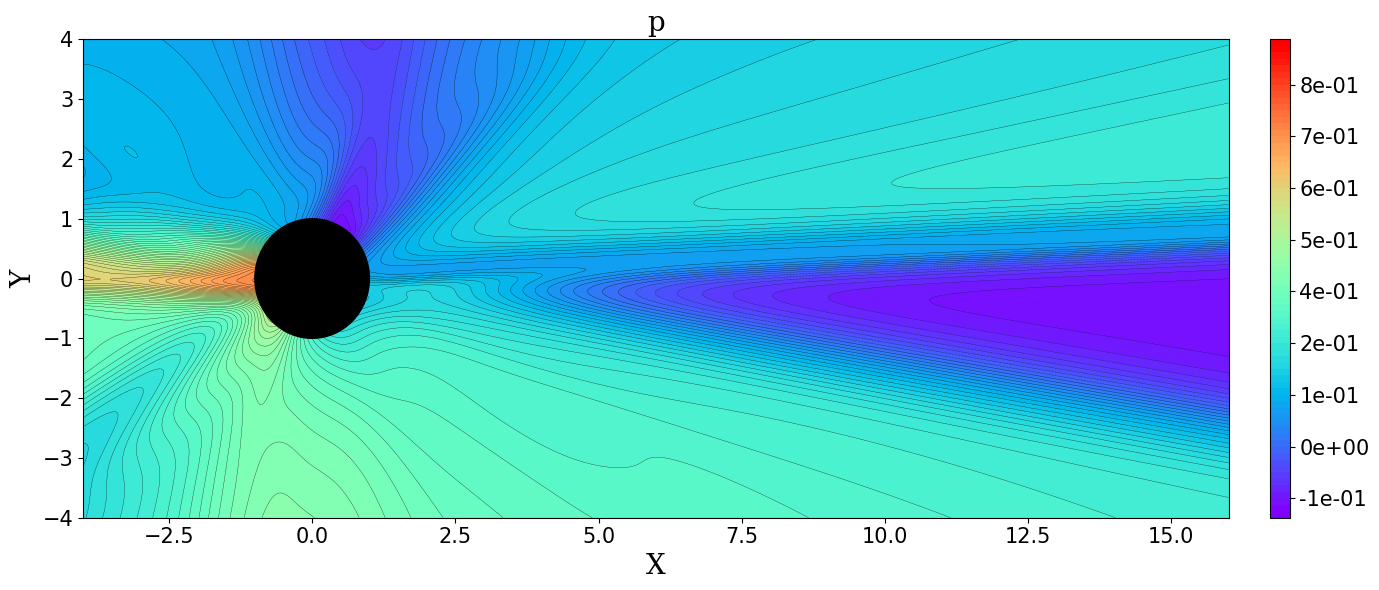

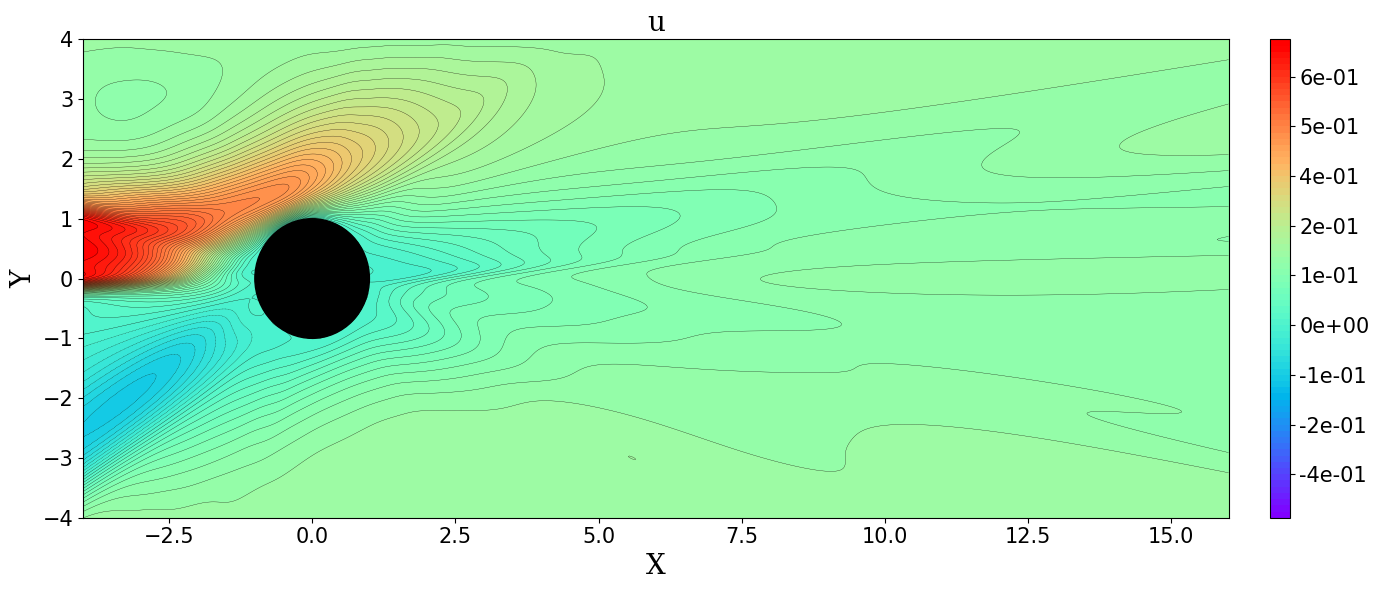

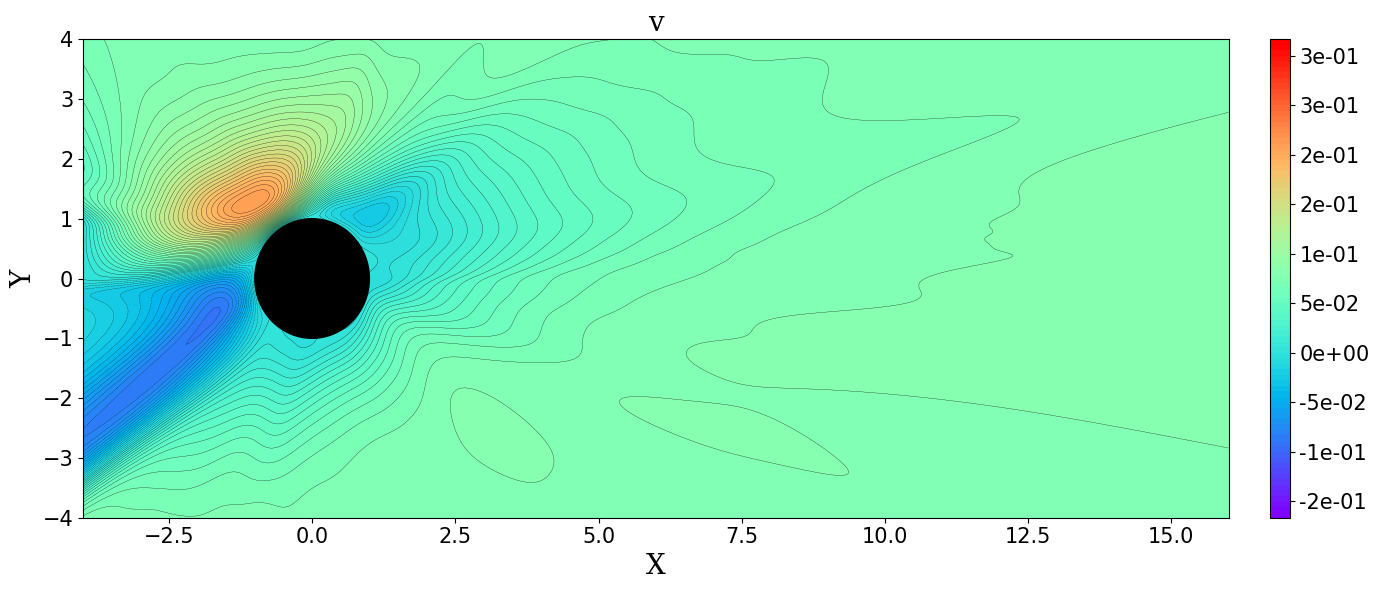

In [19]:
test_x = np.linspace(x_ini, x_f, num_test_samples)
test_y = np.linspace(y_ini, y_f, num_test_samples)
test_x, test_y = np.meshgrid(test_x, test_y)
test_shape = test_x.shape
test_xy = np.stack([test_x.flatten(), test_y.flatten()], axis=-1)
test_xy = th.tensor(test_xy, dtype=th.float32).to(device)
# predict (psi, p)
MLP.eval()
u_v_p, output_lists = MLP(test_xy)
    
u, v, p = [ u_v_p[..., i].reshape(test_shape) for i in range(u_v_p.shape[-1]) ]
u = u.detach().cpu().numpy()
v = v.detach().cpu().numpy()
p = p.detach().cpu().numpy()
# compute (u, v)
u = u.reshape(test_shape)
v = v.reshape(test_shape)
p = p.reshape(test_shape)

# plot test results
fig = plt.figure(figsize=(15, 6))
contour(test_x, test_y, p, 'p')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15, 6))
contour(test_x, test_y, u, 'u')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15, 6))
contour(test_x, test_y, v, 'v')
plt.tight_layout()
plt.show()